## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import io
import os
import requests

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Import Data

#### adding counts of varieties

In [2]:
dataset = pd.read_excel("Prepared_Datasets/merged_VNIR_SWIR_add_light_intensity.xlsx")
target = pd.read_excel("Sugar_Quantities.xlsx")

In [3]:
dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Band_407,Band_408,Band_409,Band_410,Band_411,Band_412,Band_413,Band_414,Band_415,Band_416
0,38367,2272.052376,2419.640964,2530.859162,2612.018388,2718.413619,2826.046004,2878.306089,3073.544431,3229.561130,...,2749.09,2683.93,2683.91,2628.19,2563.28,2437.80,2340.47,2268.82,2193.45,2151.58
1,38368,1822.574497,1917.456792,2003.750927,2079.778647,2153.134286,2230.324596,2276.387512,2428.686721,2552.277473,...,2170.60,2113.64,2120.91,2036.49,1966.49,1856.88,1804.88,1721.17,1650.61,1630.31
2,38369,1931.785921,2051.129682,2138.022522,2228.502649,2314.158989,2410.505299,2454.436973,2629.315374,2760.096754,...,2268.63,2224.43,2232.75,2172.08,2139.10,2025.87,1931.90,1871.97,1819.16,1791.44


In [4]:
target_columns = ['Barcode', 'Print_Info', 'Variety_ID', 'Variety', 'Batch', 'Sample', 'Glucose', 'Fructose', 'Sucrose', 'Raffinose',
                 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose', 'Total_Fructan']
target.columns = target_columns

In [5]:
# g = sns.pairplot(target[['Glucose','Fructose','Sucrose', 'Raffinose', 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose']])

In [6]:
cor2 = target.iloc[:, [7, 8, 9, 10, 11, 12, 13, 14]].corr()

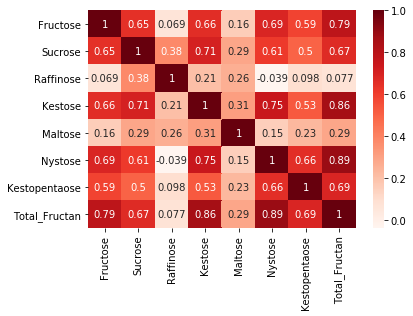

In [7]:
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

### adding helper columns on target dataset

In [9]:
counts = pd.value_counts(target['Variety_ID'])
counts_index = np.array([counts.index]).reshape(-1, 1)
counts_values = np.array([counts.values]).reshape(-1, 1)

In [10]:
counts_data = np.concatenate((counts_index, counts_values),axis = 1)

In [11]:
counts_df = pd.DataFrame(data = counts_data, columns = ['Variety_ID', 'Variety_counts'])

In [12]:
target = pd.merge(left = target, right = counts_df, how = 'outer', left_on = 'Variety_ID', right_on = 'Variety_ID')

In [13]:
# target.head(2)

#### adding variety number of counts

In [14]:
target.insert(loc = 16, column = "Variety_number", value = "")

In [15]:
for r in range(0, target.shape[0]):
    num = 0
    Variety_ID = target.Variety_ID[r]
    for x in range(r, target.shape[0]):
        if target.Variety_ID[x] == Variety_ID:
            num = num + 1
    target.Variety_number[r] = num

C:\Users\ahmad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
target.head(3)

,Barcode,Print_Info,Variety_ID,Variety,Batch,Sample,Glucose,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38368.0,Cabaret-R1_L1P3,26,Cabaret,1,1,0.525990,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
1,38632.0,Cabaret-R2_L12P3,26,Cabaret,11,251,0.587680,0.594920,14.475188,5.263027,2.500238,0.577737,0.980051,0.070338,6.219160,3,2
2,38765.0,Cabaret-R3_L17P16,26,Cabaret,18,413,0.383404,0.329895,9.469324,3.742113,1.605575,0.640902,0.251107,0.015643,4.087977,3,1


#### Max_min scaler, scaling dataset in the range of 0 and 1

In [17]:
scaler = MinMaxScaler()
scaled_dataset = dataset.iloc[:, 1:]
min_max_scaled_dataset = scaler.fit_transform(scaled_dataset)

In [18]:
min_max_scaled_dataset = pd.DataFrame(data = min_max_scaled_dataset)
min_max_scaled_dataset.insert(loc = 0, column = "img", value = dataset.Img_name)
min_max_scaled_dataset.columns = dataset.columns

In [19]:
min_max_scaled_dataset = pd.merge(left = min_max_scaled_dataset, right = target, how = "inner", left_on = "Img_name", right_on = "Barcode")
min_max_scaled_dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38367,0.453739,0.445624,0.444130,0.449550,0.458939,0.476805,0.513596,0.476022,0.478778,...,0.938528,11.580359,7.191522,2.508236,1.132254,0.454942,0.493446,7.451642,3,2
1,38368,0.336197,0.328566,0.328909,0.336866,0.342283,0.354602,0.383138,0.355403,0.357803,...,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
2,38369,0.364757,0.359725,0.358259,0.368353,0.375514,0.391563,0.421728,0.392930,0.394923,...,0.364791,11.247442,5.236240,2.417849,0.497984,1.378649,0.221425,8.311020,3,3


In [19]:
X = min_max_scaled_dataset.iloc[:, 1:417]
y = min_max_scaled_dataset.iloc[:, 423:432]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [21]:
y_train_Glucose = y_train.Glucose
y_train_Fructose = y_train.Fructose
y_train_Sucrose = y_train.Sucrose
y_train_Raffinose = y_train.Raffinose
y_train_Kestose = y_train.Kestose
y_train_Maltose = y_train.Maltose
y_train_Nystose = y_train.Nystose
y_train_Kestopentaose = y_train.Kestopentaose
y_train_Total_Fructan = y_train.Total_Fructan

y_test_Glucose = y_test.Glucose
y_test_Fructose = y_test.Fructose
y_test_Sucrose = y_test.Sucrose
y_test_Raffinose = y_test.Raffinose
y_test_Kestose = y_test.Kestose
y_test_Maltose = y_test.Maltose
y_test_Nystose = y_test.Nystose
y_test_Kestopentaose = y_test.Kestopentaose
y_test_Total_Fructan = y_test.Total_Fructan

In [22]:
# Build the neural network for glucose
model_Glucose = Sequential()
model_Glucose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Glucose.add(Dense(50, activation='relu')) # Hidden 2
model_Glucose.add(Dense(10, activation='relu')) # Hidden 3
model_Glucose.add(Dense(1)) # Output
model_Glucose.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
# Build the neural network for Fructose
model_Fructose = Sequential()
model_Fructose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Fructose.add(Dense(50, activation='relu')) # Hidden 2
model_Fructose.add(Dense(10, activation='relu')) # Hidden 3
model_Fructose.add(Dense(1)) # Output
model_Fructose.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# Build the neural network for Sucrose
model_Sucrose = Sequential()
model_Sucrose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Sucrose.add(Dense(50, activation='relu')) # Hidden 2
model_Sucrose.add(Dense(10, activation='relu')) # Hidden 3
model_Sucrose.add(Dense(1)) # Output
model_Sucrose.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# Build the neural network for Raffinose
model_Raffinose = Sequential()
model_Raffinose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Raffinose.add(Dense(50, activation='relu')) # Hidden 2
model_Raffinose.add(Dense(10, activation='relu')) # Hidden 3
model_Raffinose.add(Dense(1)) # Output
model_Raffinose.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
# Build the neural network for Kestose
model_Kestose = Sequential()
model_Kestose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Kestose.add(Dense(50, activation='relu')) # Hidden 2
model_Kestose.add(Dense(10, activation='relu')) # Hidden 3
model_Kestose.add(Dense(1)) # Output
model_Kestose.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# Build the neural network for Maltose
model_Maltose = Sequential()
model_Maltose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Maltose.add(Dense(50, activation='relu')) # Hidden 2
model_Maltose.add(Dense(10, activation='relu')) # Hidden 3
model_Maltose.add(Dense(1)) # Output
model_Maltose.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
# Build the neural network for Nystose
model_Nystose = Sequential()
model_Nystose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Nystose.add(Dense(50, activation='relu')) # Hidden 2
model_Nystose.add(Dense(10, activation='relu')) # Hidden 3
model_Nystose.add(Dense(1)) # Output
model_Nystose.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
# Build the neural network for Kestopentaose
model_Kestopentaose = Sequential()
model_Kestopentaose.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Kestopentaose.add(Dense(50, activation='relu')) # Hidden 2
model_Kestopentaose.add(Dense(10, activation='relu')) # Hidden 3
model_Kestopentaose.add(Dense(1)) # Output
model_Kestopentaose.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
# Build the neural network for Total_Fructan
model_Total_Fructan = Sequential()
model_Total_Fructan.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model_Total_Fructan.add(Dense(50, activation='relu')) # Hidden 2
model_Total_Fructan.add(Dense(10, activation='relu')) # Hidden 3
model_Total_Fructan.add(Dense(1)) # Output
model_Total_Fructan.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, 
        patience=10, verbose=1, mode='auto',
        restore_best_weights=True)
model_Glucose.fit(X_train, y_train_Glucose, validation_data=(X_test, y_test_Glucose),
        callbacks=[monitor],epochs=10000)
model_Fructose.fit(X_train, y_train_Fructose, validation_data=(X_test, y_test_Fructose),
        callbacks=[monitor],epochs=10000)
model_Sucrose.fit(X_train, y_train_Sucrose, validation_data=(X_test, y_test_Sucrose),
        callbacks=[monitor],epochs=10000)
model_Raffinose.fit(X_train, y_train_Raffinose, validation_data=(X_test, y_test_Raffinose),
        callbacks=[monitor],epochs=10000)
model_Kestose.fit(X_train, y_train_Kestose, validation_data=(X_test, y_test_Kestose),
        callbacks=[monitor],epochs=10000)
model_Maltose.fit(X_train, y_train_Maltose, validation_data=(X_test, y_test_Maltose),
        callbacks=[monitor],epochs=10000)
model_Nystose.fit(X_train, y_train_Nystose, validation_data=(X_test, y_test_Nystose),
        callbacks=[monitor],epochs=10000)
model_Kestopentaose.fit(X_train, y_train_Kestopentaose, validation_data=(X_test, y_test_Kestopentaose),
        callbacks=[monitor],epochs=10000)
model_Total_Fructan.fit(X_train, y_train_Total_Fructan, validation_data=(X_test, y_test_Total_Fructan),
        callbacks=[monitor],epochs=10000)

Train on 344 samples, validate on 115 samples
Epoch 1/10000
344/344 [==============================] - 2s 5ms/sample - loss: 0.1238 - val_loss: 0.0989
Epoch 2/10000
344/344 [==============================] - 0s 113us/sample - loss: 0.0959 - val_loss: 0.0964
Epoch 3/10000
344/344 [==============================] - 0s 136us/sample - loss: 0.0941 - val_loss: 0.1307
Epoch 4/10000
344/344 [==============================] - 0s 186us/sample - loss: 0.0912 - val_loss: 0.1207
Epoch 5/10000
344/344 [==============================] - 0s 171us/sample - loss: 0.0914 - val_loss: 0.1035
Epoch 6/10000
344/344 [==============================] - 0s 154us/sample - loss: 0.0928 - val_loss: 0.1292
Epoch 7/10000
344/344 [==============================] - 0s 220us/sample - loss: 0.0991 - val_loss: 0.0919
Epoch 8/10000
344/344 [==============================] - 0s 400us/sample - loss: 0.0917 - val_loss: 0.1185
Epoch 9/10000
344/344 [==============================] - 0s 426us/sample - loss: 0.0961 - val_loss: 

Epoch 00093: early stopping
Train on 344 samples, validate on 115 samples
Epoch 1/10000
344/344 [==============================] - 0s 1ms/sample - loss: 15.6436 - val_loss: 6.5329
Epoch 2/10000
344/344 [==============================] - 0s 148us/sample - loss: 6.3435 - val_loss: 5.0747
Epoch 3/10000
344/344 [==============================] - 0s 151us/sample - loss: 4.3862 - val_loss: 5.0667
Epoch 4/10000
344/344 [==============================] - 0s 154us/sample - loss: 4.0977 - val_loss: 4.8559
Epoch 5/10000
344/344 [==============================] - 0s 151us/sample - loss: 3.8055 - val_loss: 4.5967
Epoch 6/10000
344/344 [==============================] - 0s 174us/sample - loss: 3.5789 - val_loss: 4.3550
Epoch 7/10000
344/344 [==============================] - 0s 122us/sample - loss: 3.4684 - val_loss: 4.1742
Epoch 8/10000
344/344 [==============================] - 0s 125us/sample - loss: 3.3537 - val_loss: 4.0440
Epoch 9/10000
344/344 [==============================] - 0s 154us/sampl

344/344 [==============================] - 0s 159us/sample - loss: 0.7954 - val_loss: 0.9058
Epoch 55/10000
344/344 [==============================] - 0s 165us/sample - loss: 0.7824 - val_loss: 0.9267
Epoch 56/10000
344/344 [==============================] - 0s 183us/sample - loss: 0.8313 - val_loss: 0.8847
Epoch 57/10000
344/344 [==============================] - 0s 119us/sample - loss: 0.7959 - val_loss: 0.8942
Epoch 58/10000
344/344 [==============================] - 0s 154us/sample - loss: 0.8057 - val_loss: 1.0576
Epoch 59/10000
344/344 [==============================] - 0s 157us/sample - loss: 0.7921 - val_loss: 0.8791
Epoch 60/10000
344/344 [==============================] - 0s 142us/sample - loss: 0.8502 - val_loss: 1.0763
Epoch 61/10000
344/344 [==============================] - 0s 168us/sample - loss: 0.8777 - val_loss: 1.2636
Epoch 62/10000
344/344 [==============================] - 0s 130us/sample - loss: 0.9667 - val_loss: 0.9327
Epoch 63/10000
344/344 [===================

344/344 [==============================] - 0s 186us/sample - loss: 19.5566 - val_loss: 19.8952
Epoch 12/10000
344/344 [==============================] - 0s 145us/sample - loss: 19.9115 - val_loss: 19.8331
Epoch 13/10000
344/344 [==============================] - 0s 174us/sample - loss: 19.5284 - val_loss: 20.2932
Epoch 14/10000
344/344 [==============================] - 0s 130us/sample - loss: 19.3579 - val_loss: 20.1767
Epoch 15/10000
344/344 [==============================] - 0s 151us/sample - loss: 19.2283 - val_loss: 20.0806
Epoch 16/10000
344/344 [==============================] - 0s 159us/sample - loss: 19.1671 - val_loss: 19.9888
Epoch 17/10000
344/344 [==============================] - 0s 154us/sample - loss: 19.1106 - val_loss: 19.7701
Epoch 18/10000
344/344 [==============================] - 0s 151us/sample - loss: 19.2677 - val_loss: 19.9367
Epoch 19/10000
344/344 [==============================] - 0s 151us/sample - loss: 19.1622 - val_loss: 19.8879
Epoch 20/10000
344/344 [=

In [32]:
# predicting target values
pred_Glucose = model_Glucose.predict(X_test)
pred_Fructose = model_Fructose.predict(X_test)
pred_Sucrose = model_Sucrose.predict(X_test)
pred_Raffinose = model_Raffinose.predict(X_test)
pred_Kestose = model_Kestose.predict(X_test)
pred_Maltose = model_Maltose.predict(X_test)
pred_Nystose = model_Nystose.predict(X_test)
pred_Kestopentaose = model_Kestopentaose.predict(X_test)
pred_Total_Fructan = model_Total_Fructan.predict(X_test)

In [33]:
r2_score_Glucose = r2_score(pred_Glucose, y_test_Glucose)
r2_score_Fructose = r2_score(pred_Fructose, y_test_Fructose)
r2_score_Sucrose = r2_score(pred_Sucrose, y_test_Sucrose)
r2_score_Raffinose = r2_score(pred_Raffinose, y_test_Raffinose)
r2_score_Kestose = r2_score(pred_Kestose, y_test_Kestose)
r2_score_Maltose = r2_score(pred_Maltose, y_test_Maltose)
r2_score_Nystose = r2_score(pred_Nystose, y_test_Nystose)
r2_score_Kestopentaose = r2_score(pred_Kestopentaose, y_test_Kestopentaose)
r2_score_Total_Fructan = r2_score(pred_Total_Fructan, y_test_Total_Fructan)

In [34]:
print(r2_score_Glucose)
print(r2_score_Fructose)
print(r2_score_Sucrose)
print(r2_score_Raffinose)
print(r2_score_Kestose)
print(r2_score_Maltose)
print(r2_score_Nystose)
print(r2_score_Kestopentaose)
print(r2_score_Total_Fructan)

-10.063963147368389
-11.996035817473432
-3.374975322479293
-5.148963830473815
-7.6505844810269625
-2.948238946035978
-17.059350049665866
-26.273845112036263
-7.134058486033336


In [35]:
mean_absolute_error_Glucose = mean_absolute_error(pred_Glucose, y_test_Glucose)
mean_absolute_error_Fructose = mean_absolute_error(pred_Fructose, y_test_Fructose)
mean_absolute_error_Sucrose = mean_absolute_error(pred_Sucrose, y_test_Sucrose)
mean_absolute_error_Raffinose = mean_absolute_error(pred_Raffinose, y_test_Raffinose)
mean_absolute_error_Kestose = mean_absolute_error(pred_Kestose, y_test_Kestose)
mean_absolute_error_Maltose = mean_absolute_error(pred_Maltose, y_test_Maltose)
mean_absolute_error_Nystose = mean_absolute_error(pred_Nystose, y_test_Nystose)
mean_absolute_error_Kestopentaose = mean_absolute_error(pred_Kestopentaose, y_test_Kestopentaose)
mean_absolute_error_Total_Fructan = mean_absolute_error(pred_Total_Fructan, y_test_Total_Fructan)

In [36]:
print(mean_absolute_error_Glucose)
print(mean_absolute_error_Fructose)
print(mean_absolute_error_Sucrose)
print(mean_absolute_error_Raffinose)
print(mean_absolute_error_Kestose)
print(mean_absolute_error_Maltose)
print(mean_absolute_error_Nystose)
print(mean_absolute_error_Kestopentaose)
print(mean_absolute_error_Total_Fructan)

0.2305553585275754
0.28345138033705564
1.960859756861852
1.150255270340864
0.7103076277666065
0.16879702667549273
0.7446339157353941
0.17815441351159297
3.250590787712578


In [37]:
mean_squared_error_Glucose = mean_squared_error(pred_Glucose, y_test_Glucose)
mean_squared_error_Fructose = mean_squared_error(pred_Fructose, y_test_Fructose)
mean_squared_error_Sucrose = mean_squared_error(pred_Sucrose, y_test_Sucrose)
mean_squared_error_Raffinose = mean_squared_error(pred_Raffinose, y_test_Raffinose)
mean_squared_error_Kestose = mean_squared_error(pred_Kestose, y_test_Kestose)
mean_squared_error_Maltose = mean_squared_error(pred_Maltose, y_test_Maltose)
mean_squared_error_Nystose = mean_squared_error(pred_Nystose, y_test_Nystose)
mean_squared_error_Kestopentaose = mean_squared_error(pred_Kestopentaose, y_test_Kestopentaose)
mean_squared_error_Total_Fructan = mean_squared_error(pred_Total_Fructan, y_test_Total_Fructan)

In [38]:
print(mean_squared_error_Glucose)
print(mean_squared_error_Fructose)
print(mean_squared_error_Sucrose)
print(mean_squared_error_Raffinose)
print(mean_squared_error_Kestose)
print(mean_squared_error_Maltose)
print(mean_squared_error_Nystose)
print(mean_squared_error_Kestopentaose)
print(mean_squared_error_Total_Fructan)

0.09185004009522765
0.1327914186149303
6.183307548263873
2.0448105820174947
0.8662265184828897
0.04843139436769394
0.86997661143027
0.05287254273061167
18.836002976726046


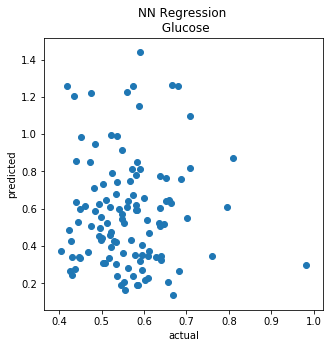

In [39]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Glucose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Glucose, y_test_Glucose)

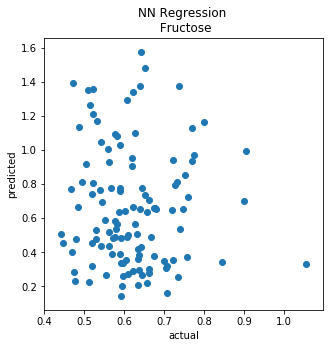

In [40]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Fructose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Fructose, y_test_Fructose)

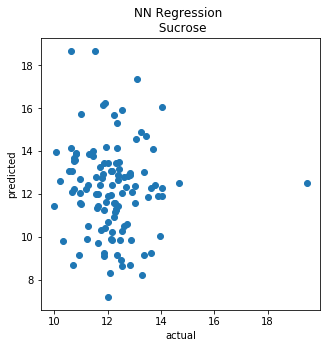

In [41]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Sucrose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Sucrose, y_test_Sucrose)

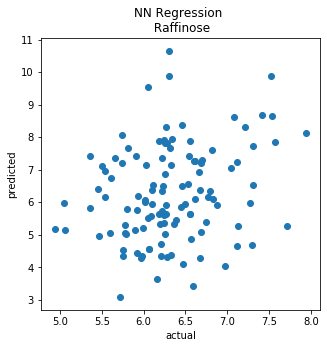

In [42]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Raffinose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Raffinose, y_test_Raffinose)

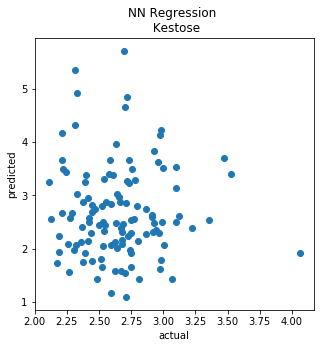

In [43]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Kestose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Kestose, y_test_Kestose)

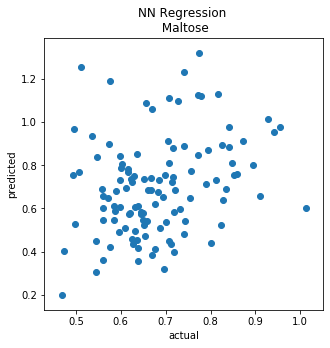

In [44]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Maltose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Maltose, y_test_Maltose)

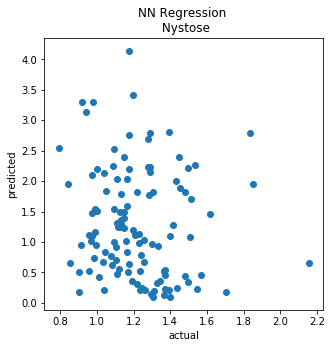

In [45]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Nystose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Nystose, y_test_Nystose)

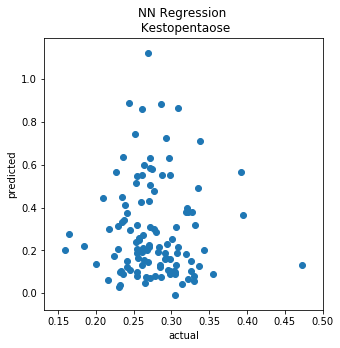

In [46]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Kestopentaose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Kestopentaose, y_test_Kestopentaose)

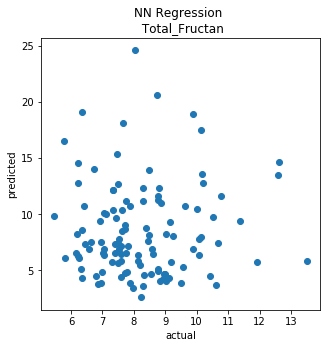

In [47]:
plt.figure(figsize=(5,5))
plt.title("NN Regression \n Total_Fructan")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(pred_Total_Fructan, y_test_Total_Fructan)